In [51]:
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
#Input to Network

from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

tf.reset_default_graph()

# Convert Entire Music .MIDI set to Tensor form 1st.  
# During training, the amount of training data sampled will likely greatly outnumber the data we have
# The NSB generator and Input Kernel are not trainable, it would be more efficient to just run the entire training and validation sets 
# through these functions one time at the beginning to generate a massive numpy tensor used for the model graph input.
# However, this will make it trickier to do batches with different #time steps
# For now: during the training loop, each iteration will involve converting the batch of .MIDI data to Note_State_Batch
# Note_State_Batch (numpy) will be used for the placeholder input to the graph


#Note State Batch (NSB) Generator
Midi_high = 102
Midi_low = 24

num_notes = Midi_high - Midi_low + 1
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None])

print(Note_State_Batch.get_shape())

#Input Kernel
input_size = 1 + 12 + 25 + 12 + 4 + 1
Note_State_Expand = Input_Kernel(Note_State_Batch)

print('Note_State_Filt Shape = ', Note_State_Expand.get_shape())


(?, 79, ?)
Note_State_Filt Shape =  (?, 79, ?, 55)


In [155]:
#lSTM Time Wise Training Graph 


#Note_State_Expand = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, input_size])
timewise_out = LSTM_TimeWise_Training_Layer(Note_State_Expand, num_units=100)



print('Time-wise output shape = ', timewise_out.get_shape())


Time-wise output shape =  (?, 79, ?, 100)


In [156]:
#LSTM Note Wise Graph

logP_out, pa_gen_out = LSTM_NoteWise_Layer(timewise_out)


print('logP out shape = ', logP_out.get_shape())
print('generated samples shape = ', pa_gen_out.get_shape())




logP out shape =  (?, 79, ?, 3)
generated samples shape =  (?, 79, ?, 1)


In [157]:
# Loss Function and Optimizer


loss = Loss_Function(Note_State_Batch, logP_out)

optimizer = tf.train.GradientDescentOptimizer(learning_rate = .1).minimize(loss)



logP :  Tensor("Reshape_9:0", shape=(?, 79, ?, 3), dtype=float32)
logP align:  Tensor("Slice:0", shape=(?, ?, ?, ?), dtype=float32)
Note_State_Batch:  Tensor("Placeholder:0", shape=(?, 79, ?), dtype=float32)
Note_State_Batch_align:  Tensor("Cast_81:0", shape=(?, ?, ?), dtype=int64)


In [159]:
# Training
N_epochs = 2
loss_hist=[]
restore_model_name = 'Trained Model'
save_model_name = 'Trained Model'
batch_size = 10
num_timesteps = 5

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, 'model/{}'.format(restore_model_name))

    for epoch in range(N_epochs):
        
        #Generate Note_State Batch numpy tensor
        batch_input = np.random.randint(low=0, high=1, size=[batch_size, num_notes, num_timesteps]).astype(np.float32)
        
        loss_out, _ = sess.run([loss, optimizer], feed_dict={Note_State_Batch: batch_input})
        print('epoch = ', epoch, '; loss = ', loss_out)
        loss_hist.append(loss_out)
        
    save_path = saver.save(sess, 'model/{}'.format(save_model_name))
    print("Model saved in file: %s" % save_path)


Load the model from: Trained Model
INFO:tensorflow:Restoring parameters from model/Trained Model
epoch =  0 ; loss =  0.349225
epoch =  1 ; loss =  0.327145
Model saved in file: model/Trained Model


In [160]:
for v in range(len(tf.trainable_variables())):
    print(tf.trainable_variables()[v])

<tf.Variable 'rnn/basic_lstm_cell/kernel:0' shape=(155, 400) dtype=float32_ref>
<tf.Variable 'rnn/basic_lstm_cell/bias:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'basic_lstm_cell/kernel:0' shape=(104, 12) dtype=float32_ref>
<tf.Variable 'basic_lstm_cell/bias:0' shape=(12,) dtype=float32_ref>


10

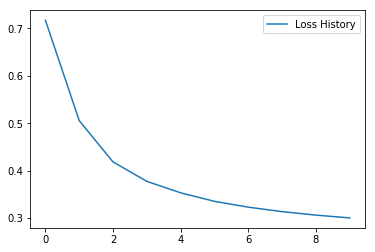

In [75]:
plt.plot(loss_hist, label="Loss History")
plt.legend()
plt.show
len(loss_hist)

In [6]:
# Music Generation
#Load Model
T_gen = 128
# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_size, num_notes, 1))
notes_gen = notes_gen_initial
notes_gen_arr=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for t in range(T_gen):
        
        notes_gen = sess.run(pa_gen_out, feed_dict = {Note_State_Batch: notes_gen})
        notes_gen_arr.append(notes_gen)
    

# input = initial note vector
# for t = 1:Tsong
#    input --> input kernel
#    run through 1 'call' of Model LSTM with present parameters / states
#    run through note-wise LSTM block as normally done to produce vector of generated samples
#    input = generated samples
#    music_sequence.append(input)

# store batch of music sequences in .MIDI files

ValueError: Cannot feed value of shape (10, 79, 1) for Tensor 'Placeholder:0', which has shape '(10, 79, 128)'

Items to Experiment with:
- different T length or variable length T from batch-to-batch for training
- categorize music, either through (unsupervised) clustering or (supervised) labeled music folders.  For clustering, the model would possibly find 'k' 'centroids' in an unsupervised manner each with its own music distribution, so during the music generation stage, 1 of these centroids would be selected for a piece of music.  
- more advanced sampling/exploring for training/music generation

In [125]:
logits = np.array([3, 3, 5], dtype=np.float32)
#label_rest = np.array([1, 0, 0])
#label_play_hold = np.array([0, .85, .15])
#label_play_artic= np.array([0, .15, .85])

#labels = label_play_hold

softmax = tf.n.softmax(logits=logits)
#loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
num_classes = 3

with tf.Session() as sess:
    p=sess.run(softmax)
    loss_run = sess.run(loss
                       )
note_gen = np.random.choice(range(num_classes), p=p)

print(loss_run)


#Will need some sort of 'for' loop for musical generation
#state_initial = tf.zeros([batch_size*num_notes, num_units])
#state = LSTMStateTuple(state_initial, state_initial) #(c, h)
#for t in range(num_timesteps):
#    cell_inputs = Note_State_Flatten[:,:,t]
#    out, state = lstmcell(cell_inputs, state)
#func = tf.reduce_mean(out_unflatten)
#gradients =  tf.train.GradientDescentOptimizer(learning_rate=.01).compute_gradients(func)

1.93954
